In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sim_data import SimData

In [3]:
from simple_hierarchical_topic_model import SimpleHierarchicalTopicModel

In [4]:
np.random.seed(1)

In [5]:
def custom_initializer(sim, topics_noise = 0.0):
    """
    A custom initializer that can be used to "cheat" and nudge the results closer
    to the desired values, based on stats from the simulation.
    We can use this to verify that variational inference can find the desired value
    if it starts sufficiently close to it.
    """
    result = dict()
    result["L"] = np.ones((sim.num_docs * sim.doc_length, sim.num_leaves))
    result["D"] = np.ones((sim.num_docs * sim.doc_length, sim.num_depths))
    result["DL"] = np.broadcast_to(sim.alpha_leaves, (sim.num_docs, sim.num_leaves))
    result["DD"] = np.broadcast_to(sim.alpha_depths, (sim.num_docs, sim.num_depths))
    init_DV = sim.topics_by_index + np.random.uniform(0.0, topics_noise, sim.topics_by_index.shape)
    result["DV"] = init_DV / np.min(init_DV)
    return result

In [6]:
%%time
sim = SimData(num_leaves = 2, num_docs = 100, doc_length = 100, topic_sharpness = 20)
docs = sim.generate()

CPU times: user 239 ms, sys: 4.36 ms, total: 243 ms
Wall time: 241 ms


In [7]:
import os
import sys
sys.path.append(os.path.abspath(".."))
import text_utils

In [8]:
%%time
data, vocab = text_utils.document_strings_to_sparse_term_doc(
    docs = docs,
    tokenizer = text_utils.default_tokenizer,
    vocab = sim.vocab)

CPU times: user 244 ms, sys: 4.03 ms, total: 248 ms
Wall time: 250 ms


In [9]:
vocab

['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9']

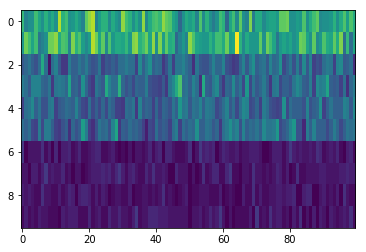

In [10]:
plt.imshow(data.todense(), aspect='auto');

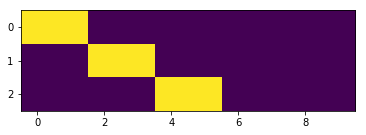

In [11]:
plt.imshow(sim.topics_by_index);

In [12]:
model = SimpleHierarchicalTopicModel(
    branching_factors = [sim.num_leaves],
    num_epochs = 100,
    batch_size = None,
    vocab = vocab,
    save_params_history = True,
    #update_order = ["D", "L", "DD", "DL", "DV", ],
    custom_initializer = custom_initializer(sim, topics_noise = 0.1),
    # ^ "cheating" with custom initializer based on simulation
)

In [13]:
model.fit(data)
top_words = model.get_top_words_by_node(num_words = 10)
model.print_top_words_by_node(num_words = 10);

100%|██████████| 10000/10000 [00:04<00:00, 2305.40it/s, Status=computing statistics]

Top words by node:
()  : w1, w0, w9, w7, w6, w8, w2, w4, w3, w5
(0,): w3, w2, w4, w6, w5, w7, w8, w1, w0, w9
(1,): w5, w4, w2, w3, w6, w7, w8, w1, w9, w0


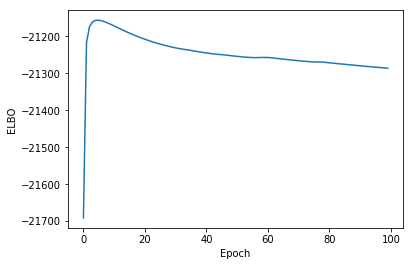

In [14]:
fig, ax = plt.subplots()
ax.plot(model.get_stats_by_epoch("epoch_index"), model.get_stats_by_epoch("ELBO"))
ax.set_xlabel("Epoch")
ax.set_ylabel("ELBO")
None

In [15]:
var_params = dict()
for name in ["DL", "DD", "DV", "L", "D"]:
    var_params[name] = model.get_stats_by_epoch("var_params_" + name)
epoch_indices = model.get_stats_by_epoch("epoch_index")

In [16]:
for k, v in var_params.items():
    print("{:2}: {}".format(k, v.shape))

L : (101, 10000, 2)
D : (101, 10000, 2)
DD: (101, 100, 2)
DL: (101, 100, 2)
DV: (101, 3, 10)


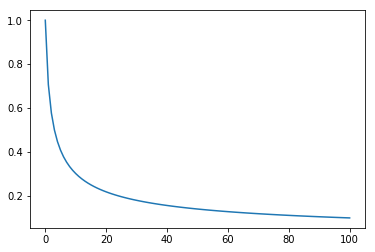

In [17]:
plt.plot(model.get_stats_by_epoch("step_size"));

In [18]:
def mean_dirichlet(X, axis = -1):
    return X / X.sum(axis = axis, keepdims = True)

In [19]:
def norm_variance_dirichlet(X, axis = -1):
    a0 = X.sum(axis = axis, keepdims = True)
    variance = X * (a0 - X) / (a0 ** 2 * (a0 + 1.0))
    norm_variance = np.linalg.norm(variance, axis = axis)
    return norm_variance

In [20]:
def mean_discrete(p, axis = -1, keepdims = False):
    axis = axis if axis >= 0 else len(p.shape) + axis
    values_target_shape = [1 if i != axis else p.shape[axis] for i in range(len(p.shape))]
    values = np.arange(p.shape[axis]).reshape(values_target_shape)
    values, p = np.broadcast_arrays(values, p)
    return np.sum(values * p, axis = axis, keepdims = keepdims)

In [21]:
def variance_discrete(p, axis = -1):
    axis = axis if axis >= 0 else len(p.shape) + axis
    values_target_shape = [1 if i != axis else p.shape[axis] for i in range(len(p.shape))]
    values = np.arange(p.shape[axis]).reshape(values_target_shape)
    values, p = np.broadcast_arrays(values, p)
    zzz = np.sum((values ** 2) * p, axis = axis)
    mean_sq = mean_discrete(p, axis = axis) ** 2
    return zzz - mean_sq

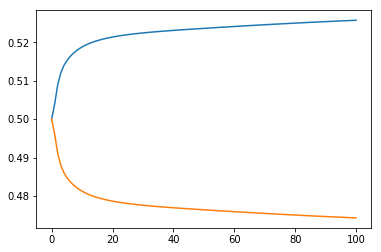

In [22]:
plt.plot(mean_dirichlet(var_params["DL"][:, 0, :]));

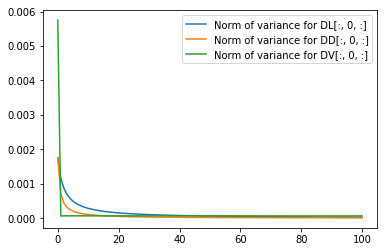

In [23]:
fig, ax = plt.subplots()
for name in ["DL", "DD", "DV"]:
    ax.plot(norm_variance_dirichlet(var_params[name][:, 0, :]),
        label = "Norm of variance for {}[:, 0, :]".format(name))
ax.legend(loc='best')
None

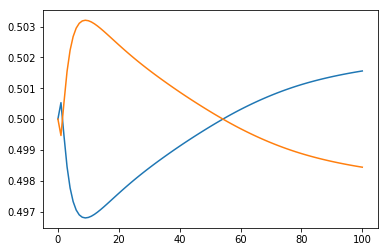

In [24]:
plt.plot(mean_dirichlet(var_params["DD"][:, 0, :]));

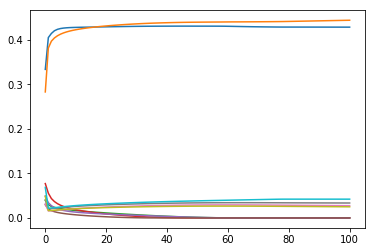

In [25]:
plt.plot(mean_dirichlet(var_params["DV"][:, 0, :]));

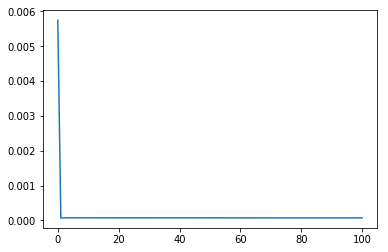

In [26]:
zzz = norm_variance_dirichlet(var_params["DV"][:, 0, :])
plt.plot(zzz);

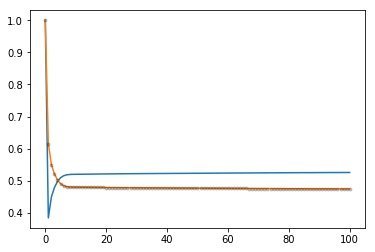

In [27]:
plt.plot(var_params["L"][:, 0, :]);
plt.plot(mean_discrete(var_params["L"][:, 0, :]), 'k.', alpha=0.2);

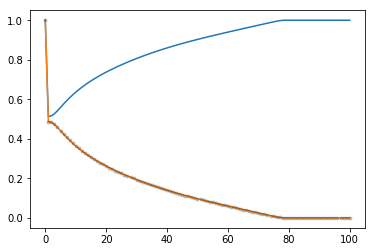

In [28]:
plt.plot(var_params["D"][:, 0, :]);
plt.plot(mean_discrete(var_params["D"][:, 0, :]), 'k.', alpha=0.2);

In [29]:
topic_vectors = model.get_expected_topic_vectors()

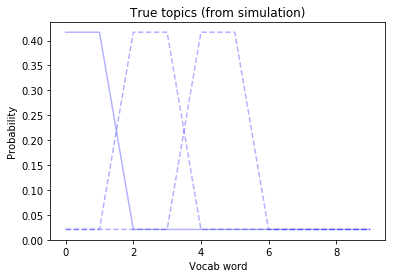

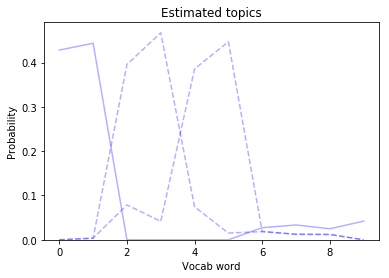

In [30]:
fig, ax = zip(*[plt.subplots() for i in range(2)])
for i in range(len(sim.nodes)):
    linestyle = '-' if i == 0 else '--'
    ax[0].plot(sim.topics_by_index[i,:], color='b', linestyle=linestyle, alpha=0.3)
    ax[1].plot(topic_vectors[i,:], color='b', linestyle=linestyle, alpha=0.3)
ax[0].set_title("True topics (from simulation)")
ax[1].set_title("Estimated topics")
for a in ax:
    a.set_xlabel("Vocab word")
    a.set_ylabel("Probability")
    a.set_ylim(0, None)
None

In [31]:
# Compare topic vectors to mean_dirichlet of most recent DV params (values should match)
zzz = mean_dirichlet(model.get_stats_by_epoch("var_params_DV")[-1, :, :])
np.linalg.norm(topic_vectors - zzz)

0.0